# Predicting US Working Visa Applications

# 3. Feature Selection

In [1]:
#Import the required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import itertools
from bs4 import BeautifulSoup
import urllib.request
import re
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
%config IPCompleter.greedy=True

#Display all columns in tables which were being left out before
#https://stackoverflow.com/questions/11707586/python-pandas-how-to-widen-output-display-to-see-more-columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 154 )

/Users/Eimg/anaconda3/envs/comp47350/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### 3.1 Randomly shuffle the rows of your dataset. 


In [2]:
# Shuffle the rows in the cleaned dataframe. 
df_visaType = pd.read_csv("US-Perm-Visa-CleanedData.csv")
df_visaType.sample(frac=1)
df_shuffle= df_visaType.sample(frac=1)

/Users/Eimg/anaconda3/envs/comp47350/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,1,2,3,4,5,6,8,13,14,17,18,21,22,23,24,25,26,27,28,29,30,31,32,34,35,37,38,39,41,44,45,46,47,48,49,54,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df_shuffle.dtypes

agent_city                        object
agent_firm_name                   object
agent_state                       object
application_type                  object
case_no                           object
case_number                       object
case_received_date                object
case_status                       object
country_of_citizenship            object
decision_date                     object
employer_address_1                object
employer_address_2                object
employer_city                     object
employer_country                  object
employer_decl_info_title          object
employer_name                     object
employer_num_employees           float64
employer_phone                    object
employer_postal_code              object
employer_state                    object
employer_yr_estab                float64
foreign_worker_info_city          object
foreign_worker_info_education     object
foreign_worker_info_inst          object
foreign_worker_i

### Datatype Issue
Above we can see that changed to datatypes made in the previous notebook have not been saved. There are only two continuous features, employer_num_employees and job_info_alt_occ_num_months. Therefore we will convert all other floats to object. 

In [4]:
df_shuffle['employer_yr_estab'] = df_shuffle['employer_yr_estab'].astype('object')
df_shuffle['fw_info_yr_rel_edu_completed'] = df_shuffle['fw_info_yr_rel_edu_completed'].astype('object')
df_shuffle['naics_us_code'] = df_shuffle['naics_us_code'].astype('object')

In [5]:
df_shuffle.shape

(153625, 72)

Examining the target feature, case_status to ensure suitability for studying.

In [6]:
df_shuffle["case_status"].value_counts()

Certified    139312
Denied        14313
Name: case_status, dtype: int64

In the cleaned dataset, of a total 153625, 139312 or 91% were certified to obtain a H-1B visa, where only 9% of cases are denied. This is an imbalanced dataset, whereby different levels of the target feature, certified and denied, are not equally represented. In order to deal with this we created a new dataset with equal levels of the target feature. Many machine learning approaches perform better with a balanced sample. If we train a model with the data as is, it will be biased and predict the majority class (certified) in most cases. Two common ways of dealing with this are undersampling the majority class or oversampling the minority category. We decided to undersample the majority class, as oversampling the 'denied' category can lead to overfitting.  

In [7]:
cert = df_shuffle.loc[df_visaType['case_status'] == 'Certified']

In [8]:
cert.shape

(139312, 72)

In [9]:
df_certified = pd.DataFrame(data=cert)

In [10]:
certified = df_certified.sample(n=14313)
certified.shape

(14313, 72)

In [11]:
denied = df_shuffle.loc[df_visaType['case_status'] == 'Denied']
denied.shape

(14313, 72)

Having created equal two dataframes, one with only certified cases and the other with the denied cases, we then merged the two dataframes.

In [12]:
frames = [denied, certified]
new = pd.concat(frames)

In [13]:
# Shuffle the rows in the new dataframe
new.sample(frac=1)
new_df= new.sample(frac=1)

In [14]:
new_df.shape

(28626, 72)

We have 72 variables in the dataset, which we felt was quite a lot. We decided to investigate these variables further and drop more, in order to focus on variables of interest and those with more potential predictive power. 

In [15]:
# Double checking whether there are null values in the data where values would be expected
new_df.isnull().sum()

agent_city                       14895
agent_firm_name                  15352
agent_state                      15065
application_type                 15444
case_no                          15444
case_number                      13182
case_received_date               13182
case_status                          0
country_of_citizenship            2513
decision_date                        0
employer_address_1                   0
employer_address_2               11992
employer_city                        0
employer_country                 13189
employer_decl_info_title         13183
employer_name                        0
employer_num_employees           13189
employer_phone                   13184
employer_postal_code                 5
employer_state                      10
employer_yr_estab                13183
foreign_worker_info_city         13183
foreign_worker_info_education    13182
foreign_worker_info_inst         13377
foreign_worker_info_major        13381
foreign_worker_info_state

As you can see there are still many variables with with a large amount of null values. We will drop any with over 60% null values. 

In [16]:
# Find columns that have less than have of the values filled in and remove them from the dataset.
for col in new_df:
    if new_df[col].count() < 17176:
        new_df = new_df.drop([col], axis = 1)

In [17]:
new_df.shape

(28626, 17)

We investigate the remaining variables' cardinality to narrow down our variables of interest.

In [18]:
new_df.describe().T

,count,unique,top,freq
case_status,28626,2,Denied,14313
country_of_citizenship,26113,154,INDIA,16208
decision_date,28626,1176,2016-06-20,119
employer_address_1,28626,11241,2200 MISSION COLLEGE BLVD.,699
employer_city,28626,2671,NEW YORK,1275
employer_name,28626,11324,COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION,698
employer_postal_code,28621,5509,95052,693
employer_state,28616,55,CALIFORNIA,6616
job_info_work_city,28626,3146,New York,1183
job_info_work_state,28623,55,CALIFORNIA,6500


In [19]:
new_df.dtypes

case_status                    object
country_of_citizenship         object
decision_date                  object
employer_address_1             object
employer_city                  object
employer_name                  object
employer_postal_code           object
employer_state                 object
job_info_work_city             object
job_info_work_state            object
pw_job_title_9089              object
pw_level_9089                  object
pw_soc_code                    object
pw_soc_title                   object
pw_source_name_9089            object
pw_unit_of_pay_9089            object
wage_offer_unit_of_pay_9089    object
dtype: object

In [20]:
# We noted that employer state has 59 values, but there are 50 states in the US, so investigated this further
new_df.employer_state.value_counts().unique

<bound method Series.unique of CALIFORNIA                  6616
TEXAS                       3693
NEW JERSEY                  2706
NEW YORK                    2067
ILLINOIS                    1500
MICHIGAN                    1054
VIRGINIA                     984
FLORIDA                      933
MASSACHUSETTS                907
PENNSYLVANIA                 875
GEORGIA                      814
WASHINGTON                   775
MARYLAND                     637
NORTH CAROLINA               563
OHIO                         444
CONNECTICUT                  322
ARIZONA                      291
MISSOURI                     257
COLORADO                     236
WISCONSIN                    230
INDIANA                      222
MINNESOTA                    217
TENNESSEE                    167
KANSAS                       153
DISTRICT OF COLUMBIA         142
LOUISIANA                    134
KENTUCKY                     128
IOWA                         110
ARKANSAS                     109
NEBRASKA    

It appears that territories have been included as states, so we will rename these as one category. We also investigated the unique values for other columns to ensure no typing errors or duplicates.

In [21]:
new_df.pw_level_9089.value_counts().unique

<bound method Series.unique of Level II     9816
Level IV     6716
Level III    4610
Level I      4480
Name: pw_level_9089, dtype: int64>

In [22]:
new_df.pw_source_name_9089.value_counts().unique

<bound method Series.unique of OES                   25127
Other                  1835
CBA                     504
Employer Conducted       34
SCA                       9
DBA                       1
Name: pw_source_name_9089, dtype: int64>

In [23]:
new_df.pw_unit_of_pay_9089.value_counts().unique

<bound method Series.unique of Year         28042
Hour           461
Week            15
Month           10
Bi-Weekly        4
Name: pw_unit_of_pay_9089, dtype: int64>

In [24]:
new_df.wage_offer_unit_of_pay_9089.value_counts().unique

<bound method Series.unique of Year         17628
Hour           228
Month           12
Week             9
Bi-Weekly        5
Name: wage_offer_unit_of_pay_9089, dtype: int64>

In [25]:
new_df_clean = new_df

In [26]:
# Grouping territories together
new_df_clean.employer_state=new_df.employer_state.replace('VIRGIN ISLANDS', 'TERRITORIES')
new_df_clean.employer_state=new_df.employer_state.replace('PUERTO RICO', 'TERRITORIES')
new_df_clean.employer_state=new_df.employer_state.replace('GUAM', 'TERRITORIES')
new_df_clean.employer_state=new_df.employer_state.replace('NORTH MARIANA ISLANDS', 'TERRITORIES')
new_df_clean.employer_state=new_df.employer_state.replace('NORTHERN MARIANA ISLANDS', 'TERRITORIES')
new_df_clean.employer_state=new_df.employer_state.replace('BRITISH COLUMBIA', 'TERRITORIES')
new_df_clean.employer_state=new_df.employer_state.replace('GU', 'TERRITORIES')
new_df_clean.employer_state=new_df.employer_state.replace('PR', 'TERRITORIES')
new_df_clean.employer_state=new_df.employer_state.replace('MP', 'TERRITORIES')
new_df_clean.employer_state=new_df.employer_state.replace('VI', 'TERRITORIES')

In [27]:
new_df_clean.describe().T

,count,unique,top,freq
case_status,28626,2,Denied,14313
country_of_citizenship,26113,154,INDIA,16208
decision_date,28626,1176,2016-06-20,119
employer_address_1,28626,11241,2200 MISSION COLLEGE BLVD.,699
employer_city,28626,2671,NEW YORK,1275
employer_name,28626,11324,COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION,698
employer_postal_code,28621,5509,95052,693
employer_state,28616,52,CALIFORNIA,6616
job_info_work_city,28626,3146,New York,1183
job_info_work_state,28623,55,CALIFORNIA,6500


We will also drop further duplicate columns that we have examined and determined have the same information, namely employer_state and job_info_work_state, employer_city and job_info_work_city.

In [28]:
new_df_clean =new_df_clean.drop('job_info_work_state', axis = 1)
new_df_clean =new_df_clean.drop('job_info_work_city', axis = 1)

We also created a new column called case_status_code and coded the outcome of the visa application denied as 0 and certified as 1.

In [29]:
case_status_types = ['Denied', 'Certified']
new_df_clean['case_status_code'] = new_df_clean.case_status.astype("category", categories=case_status_types).cat.codes

/Users/Eimg/anaconda3/envs/comp47350/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead
  


In [30]:
# Need to double check datatypes for the variables
new_df_clean.dtypes

case_status                    object
country_of_citizenship         object
decision_date                  object
employer_address_1             object
employer_city                  object
employer_name                  object
employer_postal_code           object
employer_state                 object
pw_job_title_9089              object
pw_level_9089                  object
pw_soc_code                    object
pw_soc_title                   object
pw_source_name_9089            object
pw_unit_of_pay_9089            object
wage_offer_unit_of_pay_9089    object
case_status_code                 int8
dtype: object

In [31]:
new_df_clean.to_csv("US-Perm-Visa-PlottedFeaturesBalanced.csv", encoding='utf-8', index=False)

Now we are left with categorical variables of varying cardinality. For those with lower cardinalities, we will use stacked bar chats to plot interactions between each categorical feature and the target feature, case status. For those with very high cardinalities, we will discuss below how we dealt with them.

### 3.2 For each categorical feature, plot the pairwise interaction with the target feature. Discuss what knowledge you gain from these plots, e.g., which categorical features seem to be better at predicting the target feature? Choose a subset of categorical features you find promising. Justify your choices.
    

/Users/Eimg/anaconda3/envs/comp47350/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


(0, 100)

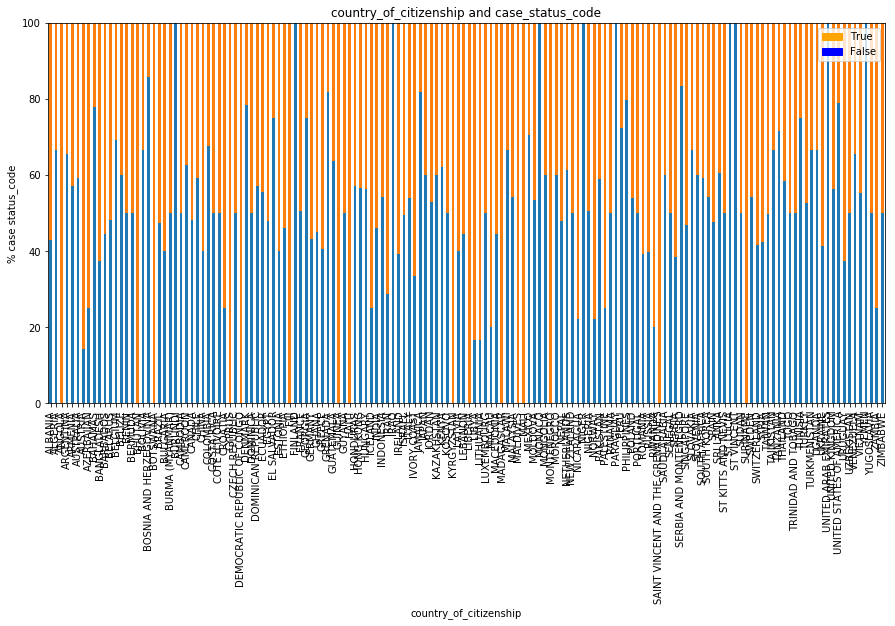

In [32]:
# country of citizenship
country_of_citizenship = pd.unique(new_df_clean.country_of_citizenship.ravel())

new_df_clean['percent'] = 0

for i in country_of_citizenship:
    count = 1 / new_df_clean[new_df_clean.country_of_citizenship == i].count()['case_status_code']
    index_list = new_df_clean[new_df_clean['country_of_citizenship'] == i].index.tolist()
    for j in index_list:
        new_df_clean.loc[j, 'percent'] = count * 100
        
group = new_df_clean[['percent','country_of_citizenship','case_status_code']].groupby(['country_of_citizenship','case_status_code']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="country_of_citizenship and case_status_code", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='orange', label='True')
blue_patch = mpatches.Patch(color='blue', label='False')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("country_of_citizenship")
my_plot.set_ylabel("% case status_code")
my_plot.set_ylim([0,100])

As we can see above, it is very difficult to glean useful information from a stacked bar chart when the cardinality is so high. Thus, we will only plot stacked bar charts for the remaining variables with lower cardinalities. 

/Users/Eimg/anaconda3/envs/comp47350/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


(0, 100)

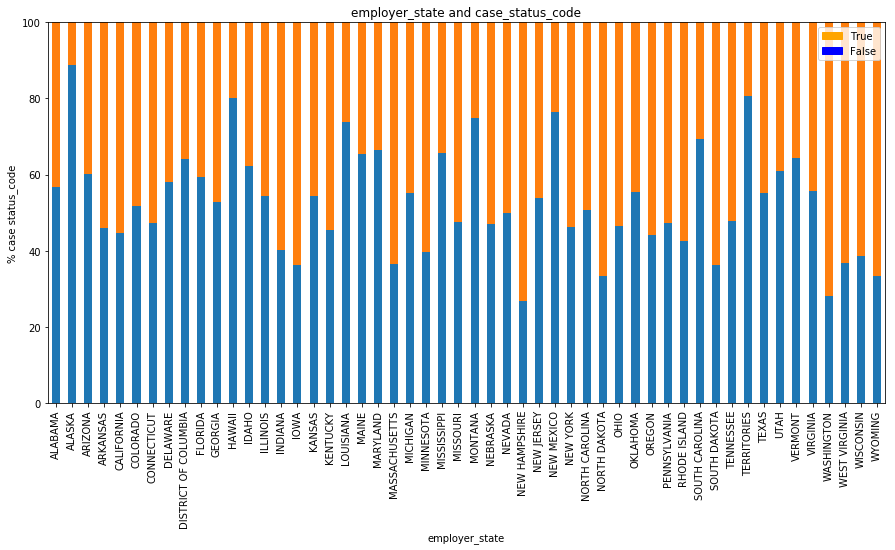

In [33]:
# employer_state                                                 
employer_state = pd.unique(new_df_clean.employer_state.ravel())

new_df_clean['percent'] = 0

for i in employer_state:
    count = 1 / new_df_clean[new_df_clean.employer_state== i].count()['case_status_code']
    index_list = new_df_clean[new_df_clean['employer_state'] == i].index.tolist()
    for j in index_list:
        new_df_clean.loc[j, 'percent'] = count * 100
        
group = new_df_clean[['percent','employer_state','case_status_code']].groupby(['employer_state','case_status_code']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="employer_state and case_status_code", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='orange', label='True')
blue_patch = mpatches.Patch(color='blue', label='False')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("employer_state")
my_plot.set_ylabel("% case status_code")
my_plot.set_ylim([0,100])


/Users/Eimg/anaconda3/envs/comp47350/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


(0, 100)

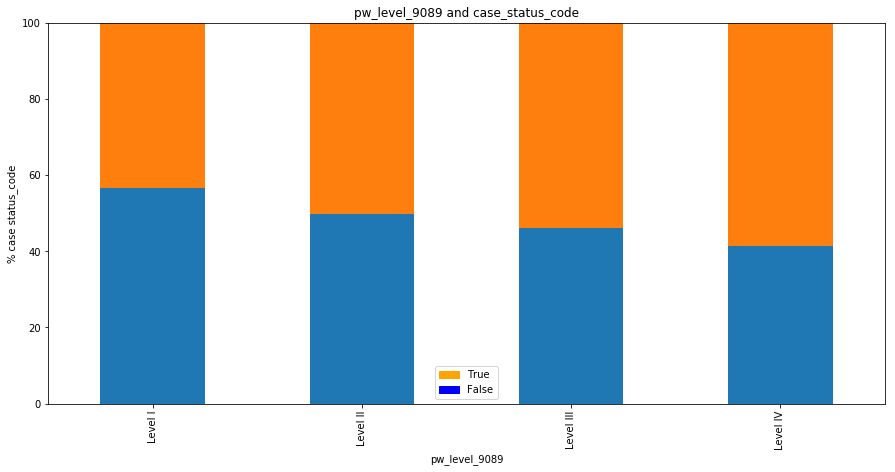

In [34]:
# pw_level_9089                                                 
pw_level_9089 = pd.unique(new_df_clean.pw_level_9089.ravel())

new_df_clean['percent'] = 0

for i in pw_level_9089:
    count = 1 / new_df_clean[new_df_clean.pw_level_9089== i].count()['case_status_code']
    index_list = new_df_clean[new_df_clean['pw_level_9089'] == i].index.tolist()
    for j in index_list:
        new_df_clean.loc[j, 'percent'] = count * 100
        
group = new_df_clean[['percent','pw_level_9089','case_status_code']].groupby(['pw_level_9089','case_status_code']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="pw_level_9089 and case_status_code", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='orange', label='True')
blue_patch = mpatches.Patch(color='blue', label='False')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("pw_level_9089")
my_plot.set_ylabel("% case status_code")
my_plot.set_ylim([0,100])



/Users/Eimg/anaconda3/envs/comp47350/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


(0, 100)

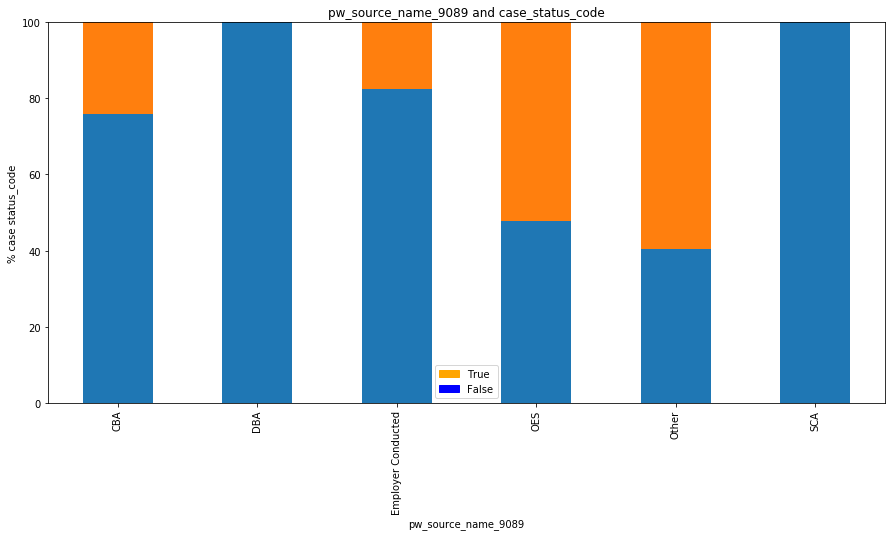

In [35]:
# pw_source_name_9089                                                 
pw_source_name_9089 = pd.unique(new_df_clean.pw_source_name_9089.ravel())

new_df_clean['percent'] = 0

for i in pw_source_name_9089:
    count = 1 / new_df_clean[new_df_clean.pw_source_name_9089== i].count()['case_status_code']
    index_list = new_df_clean[new_df_clean['pw_source_name_9089'] == i].index.tolist()
    for j in index_list:
        new_df_clean.loc[j, 'percent'] = count * 100
        
group = new_df_clean[['percent','pw_source_name_9089','case_status_code']].groupby(['pw_source_name_9089','case_status_code']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="pw_source_name_9089 and case_status_code", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='orange', label='True')
blue_patch = mpatches.Patch(color='blue', label='False')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("pw_source_name_9089")
my_plot.set_ylabel("% case status_code")
my_plot.set_ylim([0,100])


/Users/Eimg/anaconda3/envs/comp47350/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


(0, 100)

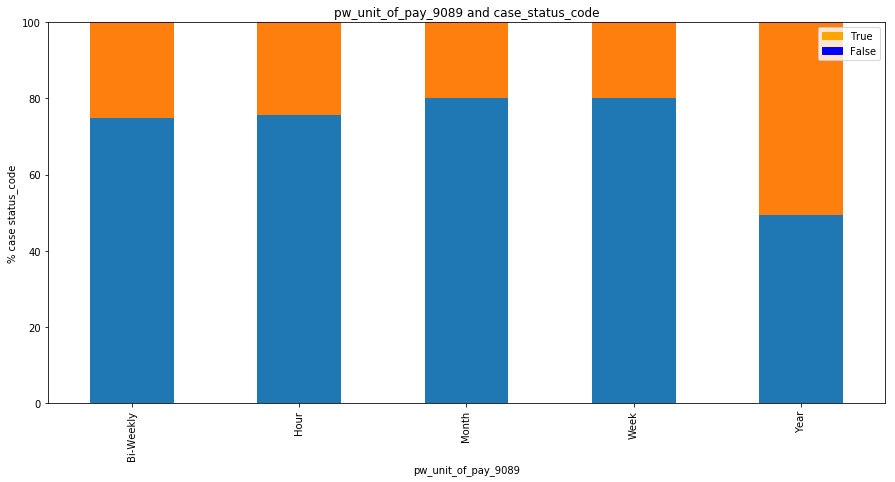

In [36]:
# pw_unit_of_pay_9089                                                 
pw_unit_of_pay_9089 = pd.unique(new_df_clean.pw_unit_of_pay_9089.ravel())

new_df_clean['percent'] = 0

for i in pw_unit_of_pay_9089:
    count = 1 / new_df_clean[new_df_clean.pw_unit_of_pay_9089== i].count()['case_status_code']
    index_list = new_df_clean[new_df_clean['pw_unit_of_pay_9089'] == i].index.tolist()
    for j in index_list:
        new_df_clean.loc[j, 'percent'] = count * 100
        
group = new_df_clean[['percent','pw_unit_of_pay_9089','case_status_code']].groupby(['pw_unit_of_pay_9089','case_status_code']).sum()
 
# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="pw_unit_of_pay_9089 and case_status_code", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='orange', label='True')
blue_patch = mpatches.Patch(color='blue', label='False')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("pw_unit_of_pay_9089")
my_plot.set_ylabel("% case status_code")
my_plot.set_ylim([0,100])


/Users/Eimg/anaconda3/envs/comp47350/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in long_scalars
  import sys


(0, 100)

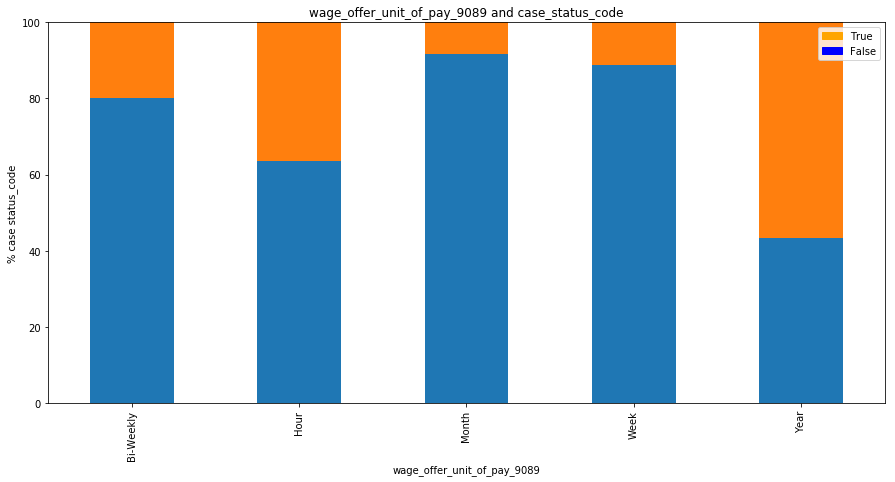

In [37]:
# wage_offer_unit_of_pay_9089                                                 
wage_offer_unit_of_pay_9089 = pd.unique(new_df_clean.wage_offer_unit_of_pay_9089.ravel())

new_df_clean['percent'] = 0

for i in wage_offer_unit_of_pay_9089:
    count = 1 / new_df_clean[new_df_clean.wage_offer_unit_of_pay_9089== i].count()['case_status_code']
    index_list = new_df_clean[new_df_clean['wage_offer_unit_of_pay_9089'] == i].index.tolist()
    for j in index_list:
        new_df_clean.loc[j, 'percent'] = count * 100
        
group = new_df_clean[['percent','wage_offer_unit_of_pay_9089','case_status_code']].groupby(['wage_offer_unit_of_pay_9089','case_status_code']).sum()

# Plot values of group in a stacked bar chart
my_plot = group.unstack().plot(kind='bar', stacked=True, title="wage_offer_unit_of_pay_9089 and case_status_code", figsize=(15,7))

# Define label colours and text and add to the plot
red_patch = mpatches.Patch(color='orange', label='True')
blue_patch = mpatches.Patch(color='blue', label='False')
my_plot.legend(handles=[red_patch, blue_patch], frameon = True)

# Define x and y labels and min and max values for the y axis
my_plot.set_xlabel("wage_offer_unit_of_pay_9089")
my_plot.set_ylabel("% case status_code")
my_plot.set_ylim([0,100])

In [38]:
new_df_clean.select_dtypes(['object']).describe().T

,count,unique,top,freq
case_status,28626,2,Denied,14313
country_of_citizenship,26113,154,INDIA,16208
decision_date,28626,1176,2016-06-20,119
employer_address_1,28626,11241,2200 MISSION COLLEGE BLVD.,699
employer_city,28626,2671,NEW YORK,1275
employer_name,28626,11324,COGNIZANT TECHNOLOGY SOLUTIONS US CORPORATION,698
employer_postal_code,28621,5509,95052,693
employer_state,28616,52,CALIFORNIA,6616
pw_job_title_9089,19403,1592,"Software Developers, Applications",4725
pw_level_9089,25622,4,Level II,9816


## Discussion on plots shown above
As some of the variables have a very high cardinality, e.g. employer_address_1, employer_name, employer_postal_code, employer_city, decision_date and pw_job_title_9089. Plotting these features as stacked bar charts has no value as it becomes impossible to see which, of which there may be many, categories are more likely to be in the certified versus denied group. 

Of the other variables of interest which we plotted, the employer state chart shows that some states like New Hampshire, Washington, North Dakota and South Dakota are are associated with more certified statuses than denied. Whereas Montana, Alaska, Maryland and the territories are associated with more denied status codes. 

Pw_level_9089 (level of the prevailing wage determination) does not tell us much but that Level IV is slightly more associated with certified than denied cases. Equally, of the pw_source_name_9089 (name of the entity providing prevailing wage information for the job) categories only OES and Other are associated with more certified cases, and DBA and SCA are only associated with denied cases. Of the wage_offer_unit_of_pay_9089, year is the only category associated more so with certified cases, whereas bi-weekly is associated with no certified cases. The same is true for pw_unit_of_pay_9089.

We picked out a number of variables of interest that we would investigate, and potentially manipulate, further, namely: country_of_citizenship, decision date, employer_name, employer_state, pw_job_title_9089, and pw_soc_title. We chose to investigate the country of citizenship as we were interested to see whether cases were more likely to be certified based on the worker coming from a certain country or region. However, as the cardinality is very high we need to investigate how we can prepare this in a more appropriate fashion for modelling. We choose also to explore the employer state as we were interested to know whether some states are associated with a higher number of certified cases, and for what reason that might be. We are interested in the decision date, as we hypothesize that the outcomes of visa applications may be affected by the political climate, so we may see changes as the US changed presidents in 2016. We chose to investigate employer name as we considered this a feature that would indicate that industries and company sizes were associated with more certified cases. We were also interested in job titles as we hypothesize that certain job titles will more likely to be granted certified. We think that visas for jobs associated with the tech industry and based in hubs like California may be more likely to be certified. 